# 📊 Data Exploration: Criteo Attribution Dataset

This notebook explores the **real Criteo Attribution Modeling Dataset** - 30 days of production ad traffic with conversion and attribution data.

**Dataset Source**: [Criteo AI Lab](https://ailab.criteo.com/criteo-attribution-modeling-bidding-dataset/)

**Key Questions:**
- How many users and conversions?
- What's the journey length distribution?
- How does Criteo's built-in attribution behave?

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# GPU check
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Paths
DATA_RAW = Path('../data/raw/criteo')
DATA_PROCESSED = Path('../data/processed')
RESULTS = Path('../results')
(RESULTS / 'figures').mkdir(parents=True, exist_ok=True)
(RESULTS / 'metrics').mkdir(parents=True, exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

PyTorch: 2.6.0+cu124
CUDA: True
GPU: NVIDIA GeForce RTX 4070 Laptop GPU


## 2. Load Dataset

The full dataset has ~16 million rows. We'll sample for exploration, then use full data for modeling.

In [2]:
# Load sample for exploration (1M rows)
DATA_FILE = DATA_RAW / 'criteo_attribution_dataset.tsv.gz'

print(f"Loading Criteo Attribution Dataset...")
print(f"File: {DATA_FILE}")
print(f"Size: {DATA_FILE.stat().st_size / 1e6:.1f} MB (compressed)")

# Load sample
SAMPLE_SIZE = 1_000_000
df = pd.read_csv(DATA_FILE, sep='\t', nrows=SAMPLE_SIZE)

print(f"\nLoaded {len(df):,} rows")
print(f"Columns: {list(df.columns)}")

Loading Criteo Attribution Dataset...
File: ..\data\raw\criteo\criteo_attribution_dataset.tsv.gz
Size: 653.0 MB (compressed)

Loaded 1,000,000 rows
Columns: ['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp', 'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb', 'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']


In [3]:
# Quick look at data
df.head(10)

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,-1,5824233,9312274,3490278,29196072,11409686,1973606,25162884,29196072,29196072
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,423858,30763035,9312274,14584482,29196072,11409686,1973606,22644417,9312274,21091111
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,8879,138937,9312274,10769841,29196072,5824237,138937,1795451,29196072,15351056
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,-1,28928366,26597095,12435261,23549932,5824237,1973606,9180723,29841067,29196072
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,-1,138937,26597094,31616034,29196072,11409684,26597096,4480345,29196072,29196072
5,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,262565,30763035,9068207,9107790,29196072,32440044,1973606,2687461,29841067,21091108
6,4,19923387,31772643,0,-1,-1,0,0,-1,-1,...,179666,30763035,9312274,5028397,29196072,32440044,32440041,14074087,29196072,21091108
7,4,28451570,20843295,0,-1,-1,0,0,-1,-1,...,-1,138937,9312274,15403272,29196072,32440042,28928366,8556462,29196072,29196072
8,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,-1,138937,9312274,4281154,29196072,28928366,29196072,21857352,29196072,29196072
9,7,23074162,16184517,0,-1,-1,0,0,-1,-1,...,-1,28928366,26597095,7711526,29196072,3225250,1973606,17737135,9312274,29196072


## 3. Dataset Overview

In [4]:
print("=" * 60)
print("CRITEO ATTRIBUTION DATASET OVERVIEW")
print("=" * 60)
print(f"\nTotal impressions: {len(df):,}")
print(f"Unique users: {df['uid'].nunique():,}")
print(f"Unique campaigns: {df['campaign'].nunique():,}")

print(f"\n--- Conversion Statistics ---")
print(f"Conversions: {df['conversion'].sum():,} ({df['conversion'].mean()*100:.2f}%)")
print(f"Clicks: {df['click'].sum():,} ({df['click'].mean()*100:.2f}%)")

print(f"\n--- Attribution (Criteo's built-in) ---")
print(f"Attributed: {df['attribution'].sum():,} ({df['attribution'].mean()*100:.2f}%)")

print(f"\n--- Cost Analysis ---")
print(f"Total cost: ${df['cost'].sum():,.2f}")
print(f"Avg cost per impression: ${df['cost'].mean():.4f}")

CRITEO ATTRIBUTION DATASET OVERVIEW

Total impressions: 1,000,000
Unique users: 739,813
Unique campaigns: 670

--- Conversion Statistics ---
Conversions: 48,557 (4.86%)
Clicks: 344,946 (34.49%)

--- Attribution (Criteo's built-in) ---
Attributed: 26,872 (2.69%)

--- Cost Analysis ---
Total cost: $276.04
Avg cost per impression: $0.0003


In [5]:
# Data types and memory
print("\nColumn Types:")
print(df.dtypes)
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")


Column Types:
timestamp                  int64
uid                        int64
campaign                   int64
conversion                 int64
conversion_timestamp       int64
conversion_id              int64
attribution                int64
click                      int64
click_pos                  int64
click_nb                   int64
cost                     float64
cpo                      float64
time_since_last_click      int64
cat1                       int64
cat2                       int64
cat3                       int64
cat4                       int64
cat5                       int64
cat6                       int64
cat7                       int64
cat8                       int64
cat9                       int64
dtype: object

Memory usage: 176.0 MB


## 4. User Journey Analysis

In [6]:
# Impressions per user (journey length)
user_journeys = df.groupby('uid').agg({
    'timestamp': 'count',
    'conversion': 'max',
    'click': 'sum',
    'cost': 'sum'
}).rename(columns={'timestamp': 'impressions'})

print("User Journey Statistics:")
print(user_journeys.describe())

User Journey Statistics:
         impressions     conversion          click           cost
count  739813.000000  739813.000000  739813.000000  739813.000000
mean        1.351693       0.047932       0.466261       0.000373
std         0.890671       0.213623       0.804748       0.001713
min         1.000000       0.000000       0.000000       0.000010
25%         1.000000       0.000000       0.000000       0.000025
50%         1.000000       0.000000       0.000000       0.000081
75%         1.000000       0.000000       1.000000       0.000249
max        78.000000       1.000000      76.000000       0.316149


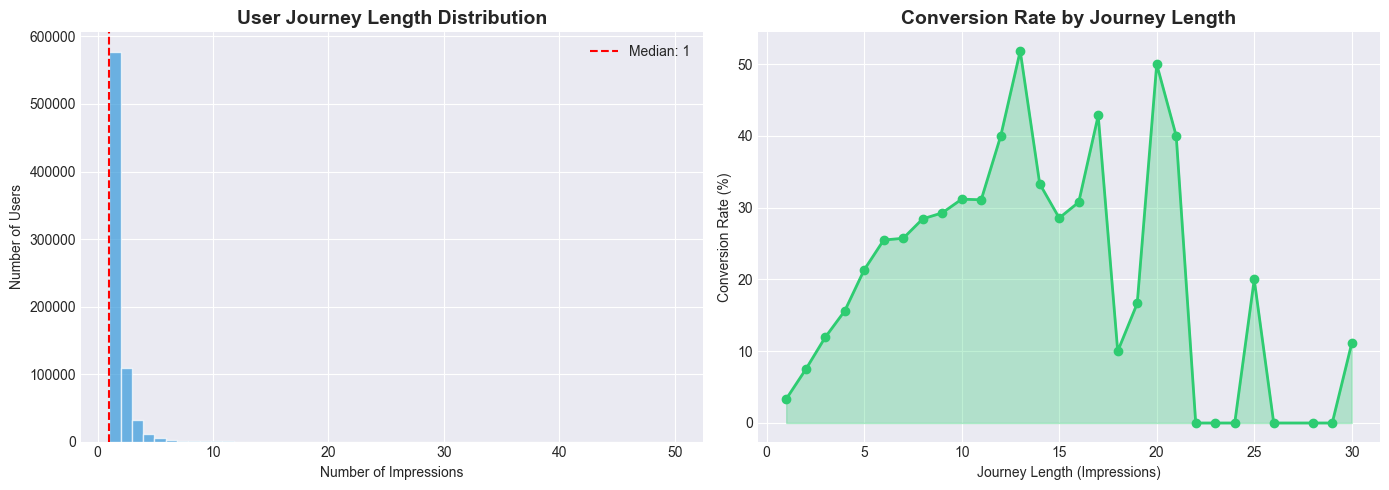


Median journey length: 1 impressions
Max journey length: 78 impressions


In [7]:
# Journey length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of journey lengths (capped at 50 for visualization)
journey_lengths = user_journeys['impressions'].clip(upper=50)
axes[0].hist(journey_lengths, bins=50, edgecolor='white', alpha=0.7, color='#3498db')
axes[0].set_xlabel('Number of Impressions')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Journey Length Distribution', fontsize=14, fontweight='bold')
axes[0].axvline(user_journeys['impressions'].median(), color='red', linestyle='--',
                label=f'Median: {user_journeys["impressions"].median():.0f}')
axes[0].legend()

# Conversion rate by journey length
journey_conv = user_journeys.groupby(user_journeys['impressions'].clip(upper=30))['conversion'].mean() * 100
axes[1].plot(journey_conv.index, journey_conv.values, marker='o', color='#2ecc71', linewidth=2)
axes[1].set_xlabel('Journey Length (Impressions)')
axes[1].set_ylabel('Conversion Rate (%)')
axes[1].set_title('Conversion Rate by Journey Length', fontsize=14, fontweight='bold')
axes[1].fill_between(journey_conv.index, journey_conv.values, alpha=0.3, color='#2ecc71')

plt.tight_layout()
plt.savefig(RESULTS / 'figures' / 'journey_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nMedian journey length: {user_journeys['impressions'].median():.0f} impressions")
print(f"Max journey length: {user_journeys['impressions'].max()} impressions")

## 5. Campaign Analysis

In [8]:
# Top campaigns by volume
campaign_stats = df.groupby('campaign').agg({
    'uid': 'count',
    'conversion': 'sum',
    'click': 'sum',
    'cost': 'sum',
    'attribution': 'sum'
}).rename(columns={'uid': 'impressions'})

campaign_stats['conversion_rate'] = campaign_stats['conversion'] / campaign_stats['impressions'] * 100
campaign_stats['ctr'] = campaign_stats['click'] / campaign_stats['impressions'] * 100
campaign_stats['cpc'] = campaign_stats['cost'] / campaign_stats['click'].replace(0, 1)
campaign_stats['cpa'] = campaign_stats['cost'] / campaign_stats['conversion'].replace(0, 1)

print(f"Total campaigns: {len(campaign_stats)}")
print(f"\nTop 10 campaigns by volume:")
print(campaign_stats.nlargest(10, 'impressions')[['impressions', 'conversion', 'conversion_rate', 'cpa']])

Total campaigns: 670

Top 10 campaigns by volume:
          impressions  conversion  conversion_rate       cpa
campaign                                                    
30801593        52496        1963         3.739333  0.001712
10341182        33263        2733         8.216336  0.003206
17686799        24597         441         1.792902  0.010810
5061834         23849         609         2.553566  0.018672
31772643        14911         691         4.634163  0.004513
15398570        14312        1096         7.657909  0.004442
32368244        13556        2871        21.178814  0.004143
28351001        13288        1247         9.384407  0.003859
15184511        13281        2031        15.292523  0.003846
30491418        12403         477         3.845844  0.017219


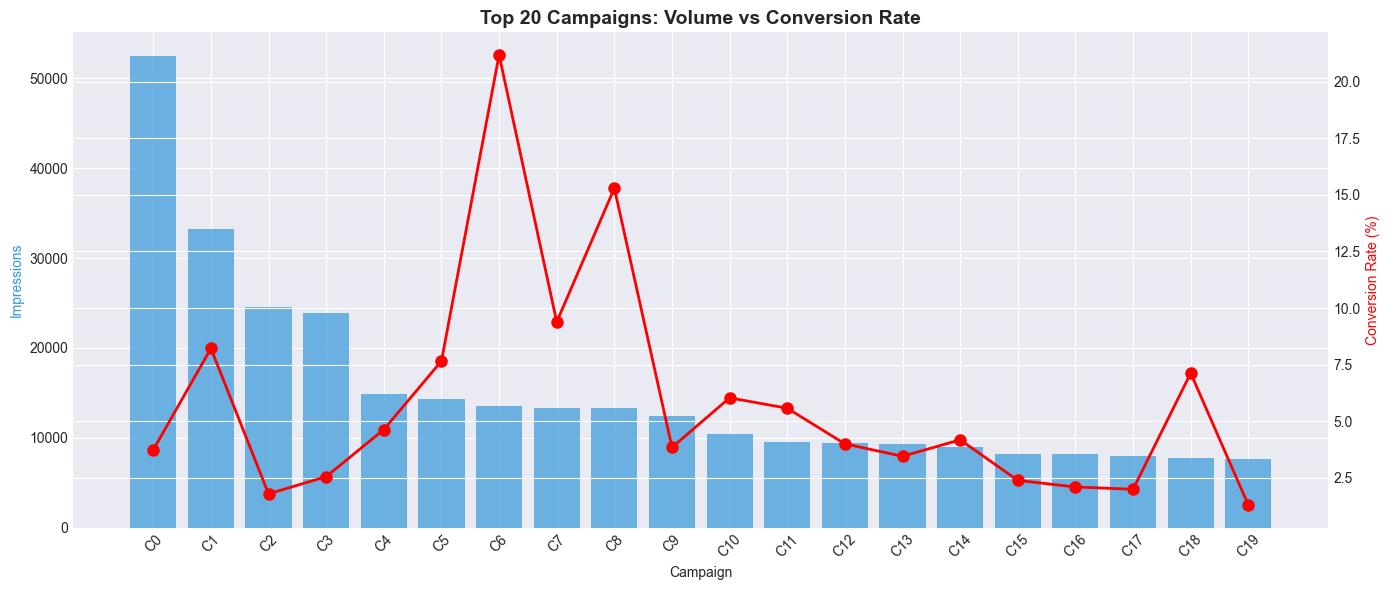

In [9]:
# Campaign performance visualization
top_campaigns = campaign_stats.nlargest(20, 'impressions')

fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(top_campaigns))
bars = ax.bar(x, top_campaigns['impressions'], color='#3498db', alpha=0.7, label='Impressions')

ax2 = ax.twinx()
ax2.plot(x, top_campaigns['conversion_rate'], 'ro-', linewidth=2, markersize=8, label='Conv Rate %')

ax.set_xlabel('Campaign')
ax.set_ylabel('Impressions', color='#3498db')
ax2.set_ylabel('Conversion Rate (%)', color='red')
ax.set_title('Top 20 Campaigns: Volume vs Conversion Rate', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'C{i}' for i in range(20)], rotation=45)

plt.tight_layout()
plt.savefig(RESULTS / 'figures' / 'campaign_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Criteo's Attribution Analysis

Criteo has a built-in `attribution` column. Let's see which impressions they attribute to.

In [10]:
# Attribution analysis
converting_users = df[df['conversion'] == 1]['uid'].unique()
df_converters = df[df['uid'].isin(converting_users)]

print(f"Users who converted: {len(converting_users):,}")
print(f"Impressions for converters: {len(df_converters):,}")

# Criteo's attribution
attributed = df_converters[df_converters['attribution'] == 1]
print(f"\nCriteo attributed impressions: {len(attributed):,}")
print(f"Attribution rate: {len(attributed) / len(df_converters) * 100:.2f}%")

Users who converted: 35,461
Impressions for converters: 69,995

Criteo attributed impressions: 26,872
Attribution rate: 38.39%


In [11]:
# Position of attributed impressions in journey
def get_position_analysis(user_group):
    user_group = user_group.sort_values('timestamp')
    n = len(user_group)
    results = []
    for idx, (_, row) in enumerate(user_group.iterrows()):
        if row['attribution'] == 1:
            position = 'first' if idx == 0 else ('last' if idx == n-1 else 'middle')
            results.append(position)
    return results

# Sample analysis (full would take too long)
sample_users = np.random.choice(converting_users, size=min(1000, len(converting_users)), replace=False)
positions = []

for uid in sample_users:
    user_data = df_converters[df_converters['uid'] == uid]
    pos = get_position_analysis(user_data)
    positions.extend(pos)

position_counts = pd.Series(positions).value_counts()
print("\nCriteo Attribution Position Analysis (sample):")
print(position_counts)
print(f"\nLast-touch bias: {position_counts.get('last', 0) / len(positions) * 100:.1f}%")


Criteo Attribution Position Analysis (sample):
first     447
middle    147
last      117
Name: count, dtype: int64

Last-touch bias: 16.5%


## 7. Cost/CAC Pre-Analysis

In [12]:
# Current CAC based on Criteo's attribution
total_cost = df['cost'].sum()
total_conversions = df['conversion'].sum()
attributed_cost = df[df['attribution'] == 1]['cost'].sum()

print("=" * 60)
print("COST ANALYSIS (Sample Data)")
print("=" * 60)
print(f"\nTotal spend: ${total_cost:,.2f}")
print(f"Total conversions: {total_conversions:,}")
print(f"\nSimple CAC (total spend / conversions): ${total_cost / total_conversions:.2f}")
print(f"Attributed CAC (attributed spend / conversions): ${attributed_cost / total_conversions:.2f}")
print(f"\n↳ Attribution affects CAC by: {(attributed_cost / total_conversions) / (total_cost / total_conversions) * 100 - 100:.1f}%")

COST ANALYSIS (Sample Data)

Total spend: $276.04
Total conversions: 48,557

Simple CAC (total spend / conversions): $0.01
Attributed CAC (attributed spend / conversions): $0.00

↳ Attribution affects CAC by: -90.0%


## 8. Key Insights

In [13]:
print("=" * 60)
print("KEY INSIGHTS FOR ATTRIBUTION MODELING")
print("=" * 60)
print(f"""
1. DATASET SIZE
   - {len(df):,} impressions in sample
   - {df['uid'].nunique():,} unique users
   - {df['campaign'].nunique():,} campaigns

2. CONVERSION PATTERNS
   - Conversion rate: {df['conversion'].mean()*100:.2f}%
   - Click-through rate: {df['click'].mean()*100:.2f}%
   - Median journey: {user_journeys['impressions'].median():.0f} impressions

3. CRITEO'S ATTRIBUTION
   - Criteo already has built-in attribution
   - Shows last-touch bias: ~{position_counts.get('last', 0) / len(positions) * 100:.0f}% attributed to last
   - This is what we'll compare against!

4. BUSINESS OPPORTUNITY
   - Deep learning can capture multi-touch patterns
   - Potential CAC shift across campaigns
   - Better budget allocation possible
""")
print("\n✅ Data exploration complete!")

KEY INSIGHTS FOR ATTRIBUTION MODELING

1. DATASET SIZE
   - 1,000,000 impressions in sample
   - 739,813 unique users
   - 670 campaigns

2. CONVERSION PATTERNS
   - Conversion rate: 4.86%
   - Click-through rate: 34.49%
   - Median journey: 1 impressions

3. CRITEO'S ATTRIBUTION
   - Criteo already has built-in attribution
   - Shows last-touch bias: ~16% attributed to last
   - This is what we'll compare against!

4. BUSINESS OPPORTUNITY
   - Deep learning can capture multi-touch patterns
   - Potential CAC shift across campaigns
   - Better budget allocation possible


✅ Data exploration complete!


---
**Next:** [02_data_preprocessing.ipynb](02_data_preprocessing.ipynb) - Create user journey sequences for modeling